# Simple Linear regression model on Salary data

To get started we will ensure that the required libraries are available:

In [ ]:

%pip install pip --upgrade pip
%pip install numpy
%pip install pandas
%pip install scipy
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Next we will import our various libraries. It may be necessary to add others as we run the notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

pd.options.mode.copy_on_write = True # This will stop a warning when cleaning our data later in the notebook

## Import our data

We will now import the data from the CSV file. The column headings are in row 0.

In [85]:
df1 = pd.read_csv('ai_job_dataset.csv', header = 0)
df2 = pd.read_csv('ai_job_dataset1.csv', header = 0)
df = pd.concat([df1, df2], ignore_index=True)


Let us see what the data looks like in the data frame.
To get an overall view of the data frame we ill use the various tools pandas gives us: head(), info(), describe() and shape:

In [ ]:
df.head()

In [ ]:
df.info()

## Cleaning our data

In the data frame above, we have a lot of data that is not relevant to my business objective.
For example, I am not interested in the 'company_name', the 'job_id', 'posting_date' and 'application_deadline' columns amongst others.

In [86]:
df_dropped = df.drop(columns = ['job_id', 'company_name', 'posting_date', 'application_deadline'], axis=1)
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_title               30000 non-null  object 
 1   salary_usd              30000 non-null  int64  
 2   salary_currency         30000 non-null  object 
 3   experience_level        30000 non-null  object 
 4   employment_type         30000 non-null  object 
 5   company_location        30000 non-null  object 
 6   company_size            30000 non-null  object 
 7   employee_residence      30000 non-null  object 
 8   remote_ratio            30000 non-null  int64  
 9   required_skills         30000 non-null  object 
 10  education_required      30000 non-null  object 
 11  years_experience        30000 non-null  int64  
 12  industry                30000 non-null  object 
 13  job_description_length  30000 non-null  int64  
 14  benefits_score          30000 non-null

With the 'salary_currency' column, we have this in USD already and we will keep some location component so we can stick to a like-for like comparison. Since we know where the company will be paying its employees, we can convert the salary to a local figure later if necessary.

I also want to make things more specific to Version 1 and the business objective we are trying to achieve.

I believe that we are more concerned with the business location of the company,(i.e. its 'territory'), so we will keep the 'company_location' column, but since an employee will have to work from one of our offices we do not require 'employee_residence'. Version 1 also deals across industries as a consultancy so the 'industry' column can also be dropped.

This time we will keep the required skills and the remote ratio.

In [87]:
df_reduced = df_dropped.drop(columns = ['salary_currency', 'salary_local', 'employee_residence', 'education_required', 'job_description_length', 'industry'], axis=1)
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         30000 non-null  object 
 1   salary_usd        30000 non-null  int64  
 2   experience_level  30000 non-null  object 
 3   employment_type   30000 non-null  object 
 4   company_location  30000 non-null  object 
 5   company_size      30000 non-null  object 
 6   remote_ratio      30000 non-null  int64  
 7   required_skills   30000 non-null  object 
 8   years_experience  30000 non-null  int64  
 9   benefits_score    30000 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 2.3+ MB


We have removed some columns that aren't relevant and have kept those that will be of use.
If we compare memory usage, we have cut this approximately in half ( 4.6Mb to approx 2.3Mb) and more cleaning will come.

Our reduced column data now looks like this:

In [ ]:
df_reduced.describe()

In [ ]:
df_reduced.shape

Having removed the irrelevant columns, we can check the data itself. We can look for Null (missing) data and duplicate entries: 

In [88]:
print("Columns    -> missing values:")
df_reduced.isnull().sum()

Columns    -> missing values:


job_title           0
salary_usd          0
experience_level    0
employment_type     0
company_location    0
company_size        0
remote_ratio        0
required_skills     0
years_experience    0
benefits_score      0
dtype: int64

In [89]:
print("Number of duplicate rows:", df_reduced.duplicated().sum())
print(df_reduced.dropna) # sanity check for missing vlues

Number of duplicate rows: 0
<bound method DataFrame.dropna of                       job_title  salary_usd experience_level employment_type  \
0         AI Research Scientist       90376               SE              CT   
1          AI Software Engineer       61895               EN              CT   
2                 AI Specialist      152626               MI              FL   
3                  NLP Engineer       80215               SE              FL   
4                 AI Consultant       54624               EN              PT   
...                         ...         ...              ...             ...   
29995        AI Product Manager       39171               MI              CT   
29996        AI Product Manager       77555               EN              CT   
29997             Data Engineer       28380               EN              FL   
29998             AI Specialist       58764               EN              PT   
29999  Principal Data Scientist       58623               

Looking at this latest output, we can see that there are some job titles which may not fit into our desired outcomes, for example, "robotics engineer" isn't a Version 1 job...
Let's filter on job_title:

Last time we removed the 'job_title' and 'suitable_roles' columns, which was a mistake, and reduced our predicition possibilities. We will now keep the 'suitable_roles' column.

In [90]:
excluded_jobs = ['Robotics', 'Autonomous Systems Engineer']

def filter_jobs(job_title):
    job_lower = job_title.lower()
    if any(ex.lower() in job_lower for ex in excluded_jobs):
        return 'Exclude'
    else:
        return 'Include'
    
df_reduced['suitable_roles'] = df_reduced['job_title'].apply(filter_jobs)
df_included_jobs = df_reduced[ df_reduced['suitable_roles'] != 'Exclude']
df_excluded_jobs = df_reduced[ df_reduced['suitable_roles'] == 'Exclude']

print("Included job_title values:")
print(df_included_jobs['job_title'].unique())

print("Excluded job_title values:")
print(df_excluded_jobs['job_title'].unique())

df_included_jobs = df_included_jobs.drop(columns = ['suitable_roles'])

print(df_included_jobs.info())
print(df_included_jobs.job_title.unique())

Included job_title values:
['AI Research Scientist' 'AI Software Engineer' 'AI Specialist'
 'NLP Engineer' 'AI Consultant' 'AI Architect' 'Principal Data Scientist'
 'Data Analyst' 'AI Product Manager' 'Machine Learning Engineer'
 'Data Engineer' 'Research Scientist' 'ML Ops Engineer' 'Head of AI'
 'Deep Learning Engineer' 'Data Scientist' 'Machine Learning Researcher'
 'Computer Vision Engineer']
Excluded job_title values:
['Autonomous Systems Engineer' 'Robotics Engineer']
<class 'pandas.core.frame.DataFrame'>
Index: 26947 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         26947 non-null  object 
 1   salary_usd        26947 non-null  int64  
 2   experience_level  26947 non-null  object 
 3   employment_type   26947 non-null  object 
 4   company_location  26947 non-null  object 
 5   company_size      26947 non-null  object 
 6   remote_ratio      26947 non-null  i

Looking at the company locations, we can see where they might fit with Version 1 offices, or not. I will simplify this and include Canada as 'North America', EU and scandanavian countries as 'Europe', 'India' and 'United Kingdon' will stay the same and I will include New Zealand and Australia as Australasia. 

In [91]:
office_mappings = {
    'North America': ['United States', 'US', 'USA', 'Canada'],
    'Europe': ['Germany', 'France', 'Spain', 'Austria', 'Italy', 'Netherlands', 'Sweden', 'Norway', 'Denmark', 'Iceland', 'Ireland', 'Switzerland', 'Finland'],
    'UK': ['United Kingdom', 'UK', 'Britain', 'Great Britain'],
    'India': ['India'],
    'Australasia': ['Australia', 'New Zealand'] #, 'Korea', 'S. Korea', 'South Korea', 'Singapore', 'Japan'
}

def select_office(company_location):
    for region, countries in office_mappings.items():
        if company_location.strip().title() in [c.title() for c in countries]:
            return region
    return 'no_office'

df_included_jobs['V1_office'] = df_included_jobs['company_location'].apply(select_office).copy()

df_clean = df_included_jobs[df_included_jobs['V1_office'] != 'no_office'].copy()
offices = list(office_mappings.keys())
df_clean = df_clean.drop(columns = 'company_location')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20220 entries, 1 to 29998
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         20220 non-null  object 
 1   salary_usd        20220 non-null  int64  
 2   experience_level  20220 non-null  object 
 3   employment_type   20220 non-null  object 
 4   company_size      20220 non-null  object 
 5   remote_ratio      20220 non-null  int64  
 6   required_skills   20220 non-null  object 
 7   years_experience  20220 non-null  int64  
 8   benefits_score    20220 non-null  float64
 9   V1_office         20220 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 1.7+ MB


An 'years_experience' integer column will be better than an 'experience_level' and finally 'company_size' and 'employment_type' are no longer needed.

In [92]:
df_final = df_clean[df_clean['employment_type'].isin(['FT', 'FL', 'CL', 'CT'])].copy()

df_final = df_final.drop(columns=['experience_level', 'company_size', 'employment_type'])

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15202 entries, 1 to 29997
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_title         15202 non-null  object 
 1   salary_usd        15202 non-null  int64  
 2   remote_ratio      15202 non-null  int64  
 3   required_skills   15202 non-null  object 
 4   years_experience  15202 non-null  int64  
 5   benefits_score    15202 non-null  float64
 6   V1_office         15202 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 950.1+ KB


We also want to pull out unique skills from the 'required_skills' column. We will allow each row up to five skills

Unique skills and their indices: {'AWS': 0, 'Azure': 1, 'Computer Vision': 2, 'Data Visualization': 3, 'Deep Learning': 4, 'Docker': 5, 'GCP': 6, 'Git': 7, 'Hadoop': 8, 'Java': 9, 'Kubernetes': 10, 'Linux': 11, 'MLOps': 12, 'Mathematics': 13, 'NLP': 14, 'PyTorch': 15, 'Python': 16, 'R': 17, 'SQL': 18, 'Scala': 19, 'Spark': 20, 'Statistics': 21, 'Tableau': 22, 'TensorFlow': 23}


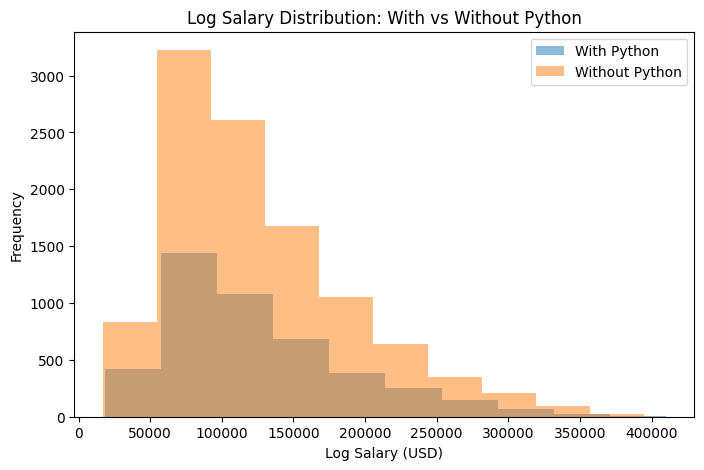

In [93]:
# Split all required_skills into a flat list
all_skills = df_final['required_skills'].str.split(',').explode().str.strip()

# Get unique skills and create a dictionary mapping skill to index
unique_skills = sorted(all_skills.dropna().unique())
skills_dict = {skill: idx for idx, skill in enumerate(unique_skills)}

# Optionally, add a column with the list of skills for each row
df_final['skills_list'] = df_final['required_skills'].str.split(',').apply(lambda x: [s.strip() for s in x] if isinstance(x, list) else [])

# Optionally, add a column with the skill indices for each row
df_final['skills_indices'] = df_final['skills_list'].apply(lambda skills: [skills_dict[s] for s in skills if s in skills_dict])

# Assume skills_dict and df_final['skills_list'] already exist
max_skills = 5  # or another reasonable number

for i in range(max_skills):
    df_final[f'skill_{i+1}'] = df_final['skills_list'].apply(
        lambda skills: skills_dict[skills[i]] if len(skills) > i and skills[i] in skills_dict else -1
    )

# Optionally, drop the original list columns
df_final = df_final.drop(columns=['skills_list', 'skills_indices', 'required_skills'])

print("Unique skills and their indices:", skills_dict)

python_idx = skills_dict['Python']
has_python = (
    (df_final['skill_1'] == python_idx) |
    (df_final['skill_2'] == python_idx) |
    (df_final['skill_3'] == python_idx) |
    (df_final['skill_4'] == python_idx) |
    (df_final['skill_5'] == python_idx)
)

plt.figure(figsize=(8,5))
df_final.loc[has_python, 'salary_usd'].plot(kind='hist', alpha=0.5, label='With Python')
df_final.loc[~has_python, 'salary_usd'].plot(kind='hist', alpha=0.5, label='Without Python')
plt.legend()
plt.title('Log Salary Distribution: With vs Without Python')
plt.xlabel('Log Salary (USD)')
plt.show()

Having made sure we have checked for missing or null values (which we would have removed if found), excluded some jobs that aren't in line with Version 1 capabilities, we can now see which columns produce the most unique values:

In [94]:
df_final.nunique().sort_values(ascending = True)

remote_ratio            3
V1_office               5
job_title              18
years_experience       20
skill_2                24
skill_1                24
skill_3                24
skill_4                25
skill_5                25
benefits_score         51
salary_usd          14611
dtype: int64

From this, the number of most unique values is obtained from the 'salary_usd' column. We can see what the distribution of the salaries looks like:

<Axes: xlabel='salary_usd', ylabel='Count'>

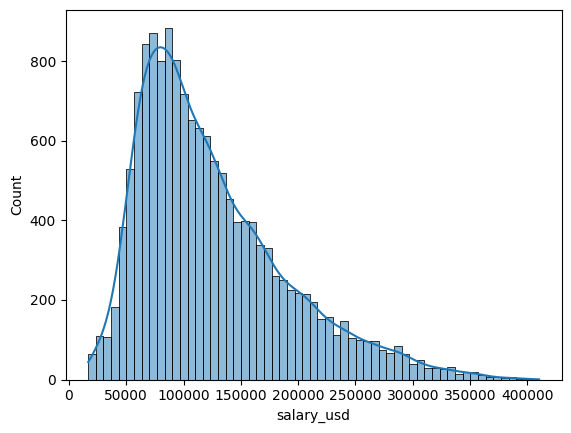

In [95]:
sb.histplot(data=df_final['salary_usd'], kde = True)

This plot suggests we might want to use the log of our salary for a better distribution.
Applying a log transformation to salary (creating log_salary_usd) is a common best practice in regression tasks when the target variable (salary) is highly skewed or spans several orders of magnitude. Here’s why this is advantageous:

1. Reduces Skewness:
Salaries are often right-skewed (many low values, few very high values). Log transformation makes the distribution more symmetric and closer to normal, which is an assumption for many regression models.

2. Stabilizes Variance:
Log transformation reduces heteroscedasticity (when the spread of residuals increases with the value of the target). This helps the model fit better and makes errors more consistent across the range of values.

3. Improves Model Performance:
Linear regression and similar models work best when the relationship between features and target is linear and the errors are normally distributed. Log-transforming the target often makes these assumptions more valid, leading to better predictions and more reliable confidence intervals.

Best Practice:

Use log_salary_usd as your target if the original salary distribution is highly skewed or has outliers.
After prediction, you can convert predictions back to the original scale using np.expm1().
Summary:
Log-transforming salary helps your model by making the data more normal, reducing the impact of outliers, and improving the reliability of your regression results. This is standard practice in salary and income modeling.

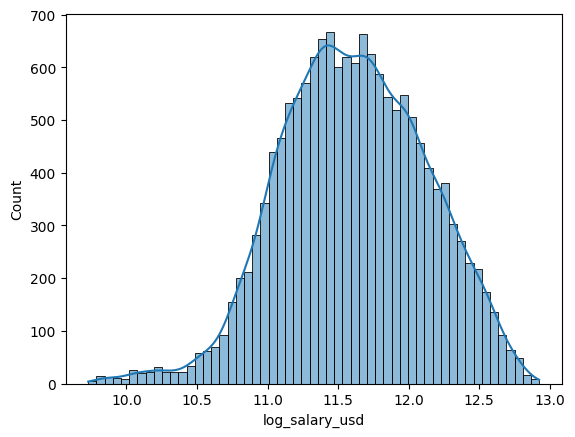

In [96]:
df_final['log_salary_usd'] = np.log1p(df_final['salary_usd'])
sb.histplot(data=df_final['log_salary_usd'], kde = True)
df_final.drop(columns = 'salary_usd', inplace = True)

As we are doing this transformation, we can look at regularizing columns such as the years_experience and the benefits_score:

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_final[['benefits_score', 'years_experience']] = scaler.fit_transform(df_final[['benefits_score', 'years_experience']])

df_final[['benefits_score', 'years_experience']].describe()

,benefits_score,years_experience
count,1.520200e+04,1.520200e+04
mean,6.422087e-16,-7.384933e-17
std,1.000033e+00,1.000033e+00
min,-1.729951e+00,-1.134544e+00
25%,-9.008245e-01,-7.784881e-01
50%,-2.604314e-03,-2.444047e-01
75%,8.956159e-01,6.457343e-01
max,1.724742e+00,2.247984e+00


While we have reduced the number of columns and reduced the number of rows to suit our needs, we still have data in our final frame that we will need to be converted from an object to a bool or numeric value. This will be done by labelling the columns and using one-hot encoding if necessary.
- V1_office  

In [99]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df_final['V1_office'] = le.fit_transform(df_final['V1_office'])
# df_final['job_title'] = le.fit_transform(df_final['job_title'])

job_title_dummies = pd.get_dummies(df_final['job_title'], prefix='job', drop_first=True)
print(f"One-hot encoding created {job_title_dummies.shape[1]} binary columns for job titles")

df_final = pd.concat([df_final, job_title_dummies], axis=1)
df_final = df_final.drop('job_title', axis=1)


df_final.info()

One-hot encoding created 17 binary columns for job titles
<class 'pandas.core.frame.DataFrame'>
Index: 15202 entries, 1 to 29997
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   remote_ratio                     15202 non-null  int64  
 1   years_experience                 15202 non-null  float64
 2   benefits_score                   15202 non-null  float64
 3   V1_office                        15202 non-null  object 
 4   skill_1                          15202 non-null  int64  
 5   skill_2                          15202 non-null  int64  
 6   skill_3                          15202 non-null  int64  
 7   skill_4                          15202 non-null  int64  
 8   skill_5                          15202 non-null  int64  
 9   log_salary_usd                   15202 non-null  float64
 10  job_AI Consultant                15202 non-null  bool   
 11  job_AI Product Manager     

We should do something similar with the V1_office column:

In [103]:
office_dummies = pd.get_dummies(df_final['V1_office'], prefix='Hub', drop_first=True)
print(f"One-hot encoding created {office_dummies.shape[1]} binary columns for job titles")

df_final = pd.concat([df_final, office_dummies], axis=1)
df_final = df_final.drop('V1_office', axis=1)


df_final.info()

One-hot encoding created 4 binary columns for job titles
<class 'pandas.core.frame.DataFrame'>
Index: 15202 entries, 1 to 29997
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   remote_ratio                     15202 non-null  int64  
 1   years_experience                 15202 non-null  float64
 2   benefits_score                   15202 non-null  float64
 3   skill_1                          15202 non-null  int64  
 4   skill_2                          15202 non-null  int64  
 5   skill_3                          15202 non-null  int64  
 6   skill_4                          15202 non-null  int64  
 7   skill_5                          15202 non-null  int64  
 8   log_salary_usd                   15202 non-null  float64
 9   job_AI Consultant                15202 non-null  bool   
 10  job_AI Product Manager           15202 non-null  bool   
 11  job_AI Research Scientist   

Let's have a look at some relationships:

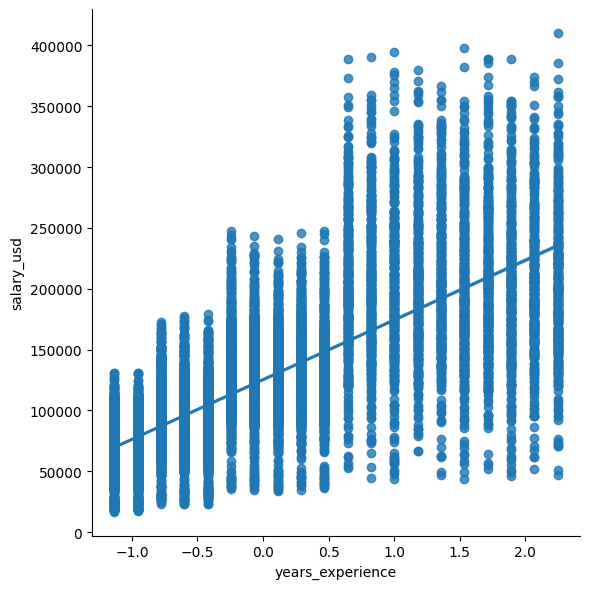

In [105]:
df_final_plot = df_final.copy()

df_final_plot['salary_usd'] = np.expm1(df_final_plot['log_salary_usd'])
sb.lmplot(x='years_experience', y='salary_usd', data=df_final_plot, height=6, palette='Set1')

## Building the model

We could now create our 'X' and 'y' datasets, with 'salary_usd' being our prediction target:

We will start with a 75/25 split between training and testing data, and a random_state of 42 (From the hitchhikers guide to the galaxy)

In [106]:
from sklearn.model_selection import train_test_split
y = df_final['log_salary_usd']
X = df_final.drop(columns=['log_salary_usd'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12921, 29)
y_train shape: (12921,)
X_test shape: (2281, 29)
y_test shape: (2281,)


Lets add a correlation map. 1 = perfect correlation, 0 means no correlation:

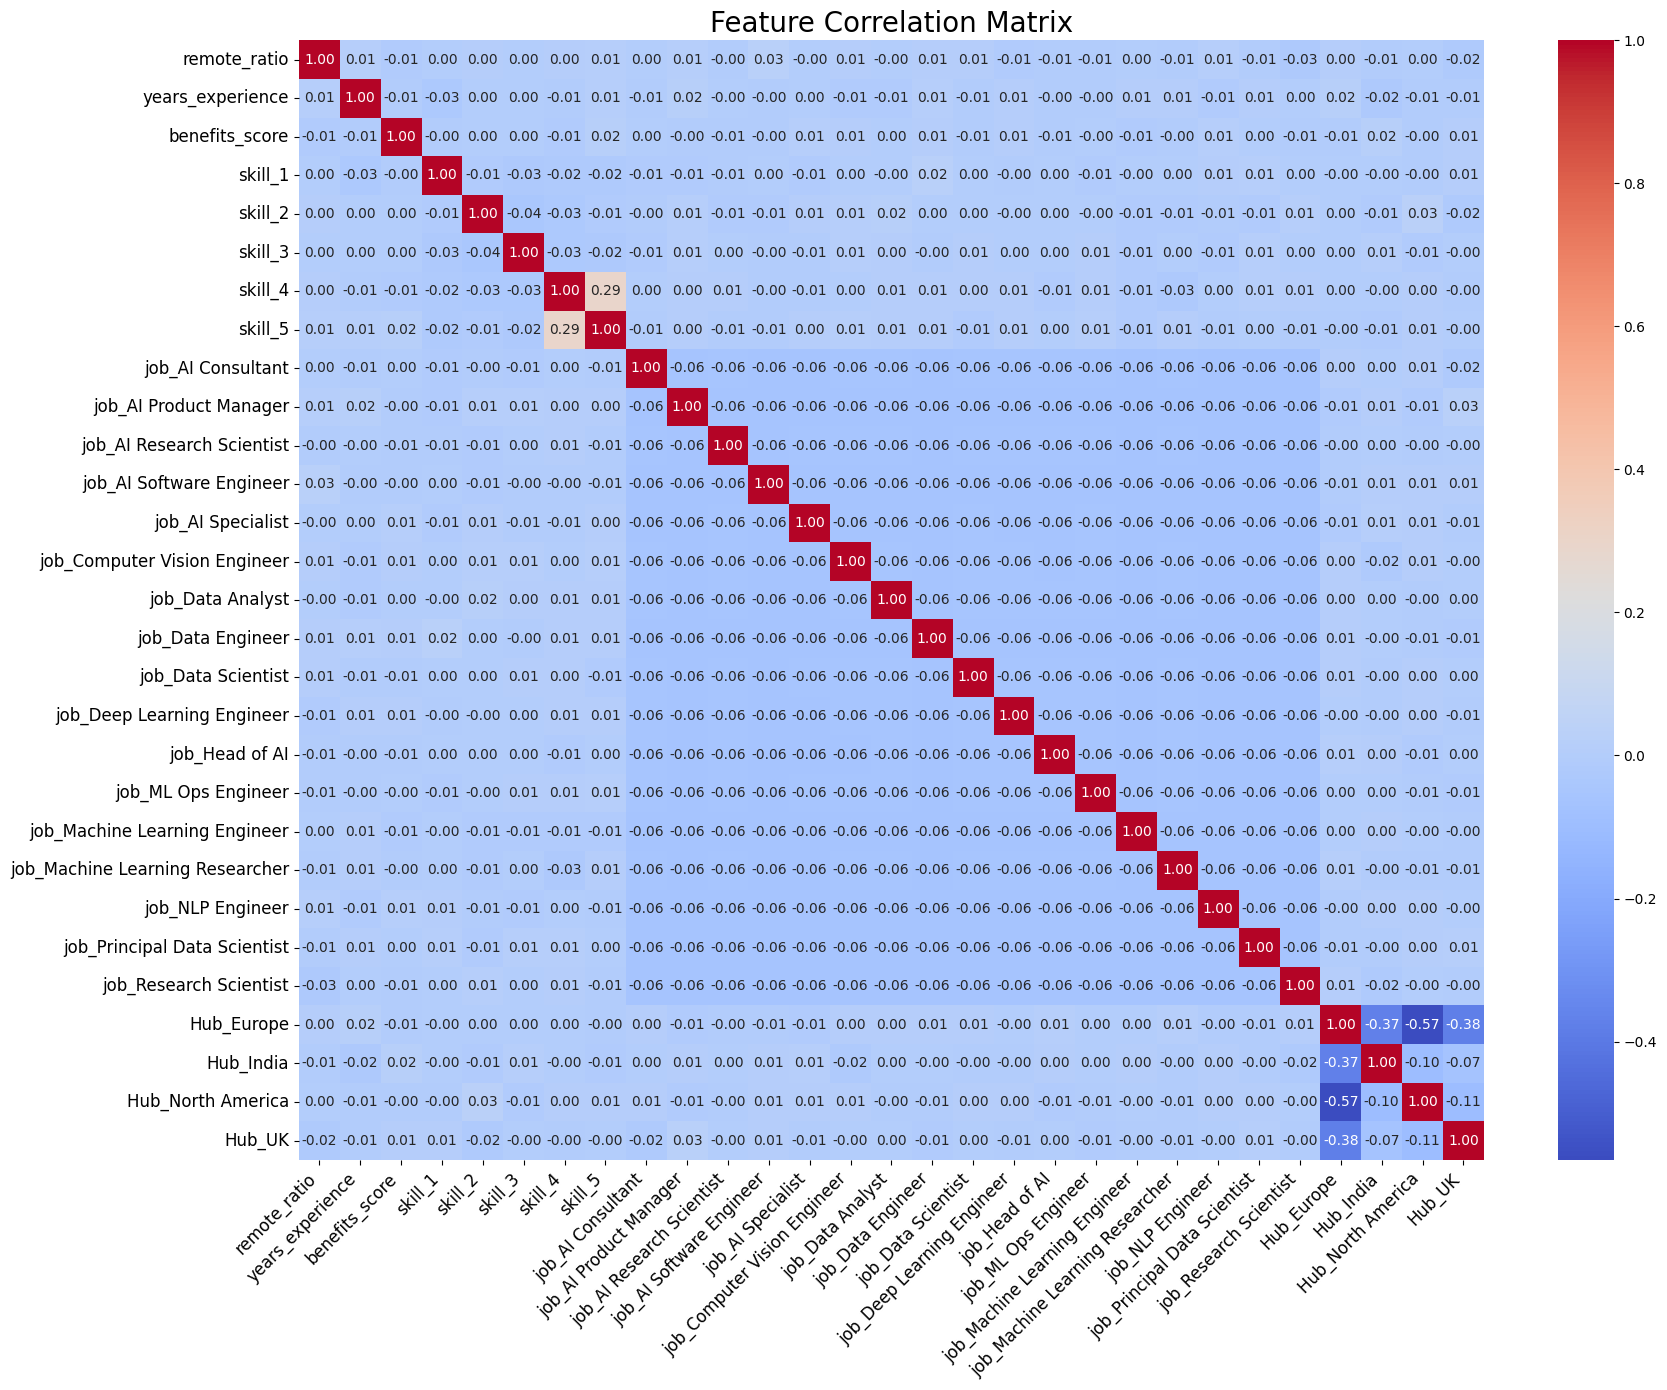

In [108]:
corr_mat = X_train.corr()
plt.figure(figsize=(18, 14))
sb.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix", fontsize=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

To be fair, this isn't telling us a lot. However, this is a second iteration.

And now we will create a simple linear regression model:

In [109]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Model coefficients: [ 3.57812556e-05  3.79755913e-01  4.15339019e-04  7.89479860e-04
 -2.12249520e-04 -4.37033711e-04  3.12438076e-04 -5.20940125e-04
  1.00513471e-03  8.86373016e-03  6.86447102e-03 -4.68134724e-03
 -5.15703892e-03  8.45779610e-04 -1.59807523e-02  2.58610069e-02
  1.22966539e-02  5.64707005e-03 -5.36266434e-03 -4.75894547e-03
  5.86899314e-03 -1.23522505e-03  2.49681312e-03  8.52800154e-03
  8.81779076e-03  3.34172357e-02 -6.87691166e-01  4.65040489e-02
  5.15505556e-02]
R2 score training: 0.6706572382806334
R2 score testing: 0.6707325882121429
R2 score : 0.6707325882121429 , MAE: 0.23607076958531162
count    15202.000000
mean         2.533584
std          0.041108
min          2.372941
25%          2.505422
50%          2.533959
75%          2.563519
max          2.633656
Name: log_salary_usd, dtype: float64
Mean Salary is:  2.5335835451056865
Relative MAE: 2.0337%
True R2 score : 0.5878705481361146 ,True MAE: 29411.45685915979


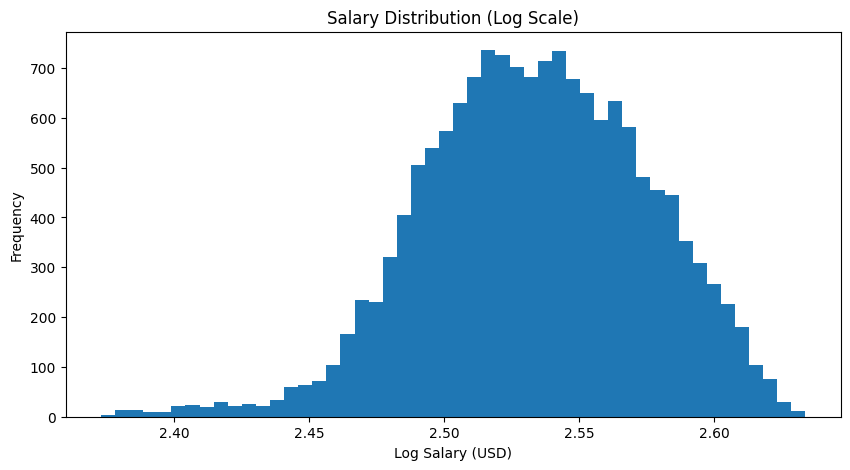

In [110]:
print("Model coefficients:", model.coef_)
print("R2 score training:", model.score(X_train, y_train))
print("R2 score testing:", model.score(X_test, y_test))

y_predict = model.predict(X_test)

from sklearn.metrics import r2_score, mean_absolute_error

print(f'R2 score : {r2_score(y_true=y_test,y_pred=y_predict)} , MAE: {mean_absolute_error(y_test,y_predict)}')

df_final['log_salary_usd'] = np.log1p(df_final['log_salary_usd'])
print(df_final['log_salary_usd'].describe())
df_final['log_salary_usd'].plot(kind='hist', bins=50, figsize=(10, 5), title='Salary Distribution (Log Scale)', xlabel='Log Salary (USD)', ylabel='Frequency')
print("Mean Salary is: ", df_final['log_salary_usd'].mean())

relative_mae = (mean_absolute_error(y_test, y_predict) / y_test.mean())*100
print(f'Relative MAE: {relative_mae:.4f}%')

true_y_predict=np.expm1(y_predict)
true_y_test=np.expm1(y_test)
print(f'True R2 score : {r2_score(y_true=true_y_test,y_pred=true_y_predict)} ,True MAE: {mean_absolute_error(true_y_test,true_y_predict)}')


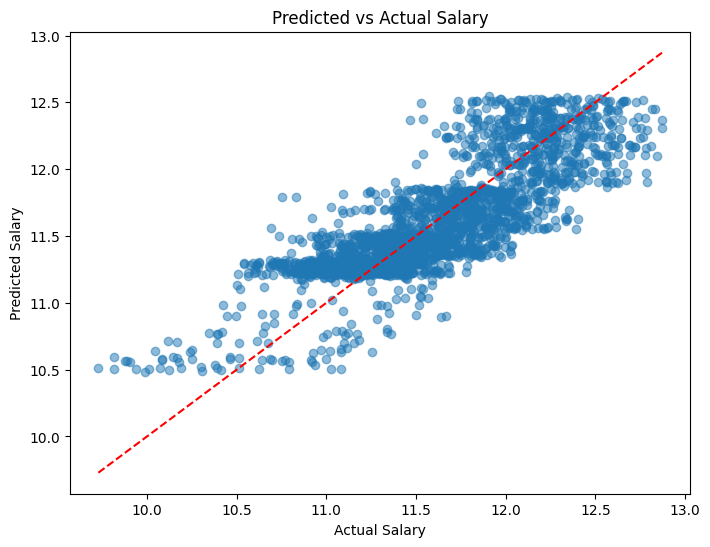

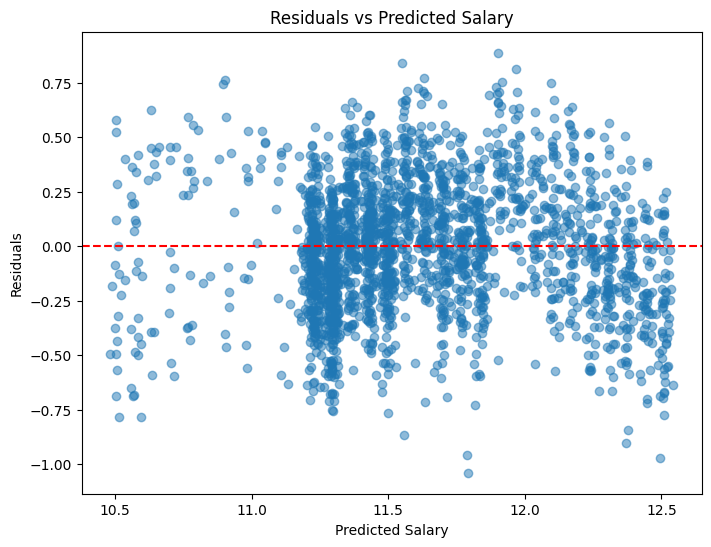

In [111]:
# 1. Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Predicted vs Actual Salary')
plt.show()

# 2. Residuals Plot
residuals = y_test - y_predict
plt.figure(figsize=(8,6))
plt.scatter(y_predict, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Salary')
plt.show()